# Computing vertical stress gradient from hot-film anemometers in SUSTAIN

In this notebook I attempt to compute the vertical stress gradient from the hot-film anemomoeter data in SUSTAIN.
This is important because the eddy-covariance stress measurements inside the tank are highly dependent on the height
from the water surface.
They are highly dependent on height because stress is not constant in the tank--as we often assume for the atmospheric boundary layer--but it decreases as we go up from the water surface and toward the tank ceiling.

## Procedure

1. Read raw hot-film data [V]
2. Read raw pressure data from pitot-tubes and tank ceiling [Pa]
3. Compute pitot wind speed based on (2)
4. Fit-hot film voltages (1) to pitot wind speed (3) to obtain hot-film u and w velocities [m/s]
5. Compute eddy-covariance stress [$N/m^2$] from (4)
6. Compute vertical stress gradient $\dfrac{\partial \tau}{\partial z}$ [$N/m^3$] from hot-film velocities (5), from different heights
7. Compute along-tank pressure gradient $\dfrac{\partial p}{\partial x}$ [Pa/m] from pressure data (2)
8. Compute a linear fit of $\dfrac{\partial \tau}{\partial z}$ (6) to $\dfrac{\partial p}{\partial x}$ (7)
9. Apply the stress-pressure gradient relationship (8) to correct the stress from IRGASON from the height of the instrument to the surface

In [1]:
from asist.hotfilm import effective_velocity, hotfilm_velocity
from asist.utility import binavg, running_mean
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.signal import detrend
from sustain_drag_2020.fetch import fetch

import matplotlib
font = {'size': 16}
matplotlib.rc('font', **font)

## Step 1: Read raw hot-film data

In [2]:
def read_hotfilm(filename):
    """Reads raw hot-film data from file and returns it 
    as arrays of voltages from channels 1 and 2."""
    data = open(filename).readlines()
    date = data[0].strip()
    time = data[1].strip()
    month, day, year = [int(a) for a in date.split('/')]
    hour, minute, second = [int(a) for a in time.split()[0].split(':')]
    start_time = datetime(year, month, day, hour, minute, second)
    seconds, ch1, ch2 = [], [], []
    for line in data[8:]:
        values = line.strip().split('\t')
        seconds.append(float(values[0]))
        ch1.append(float(values[3]))
        ch2.append(float(values[4]))
    seconds = np.array(seconds)
    ch1 = np.array(ch1)
    ch2 = np.array(ch2)
    return seconds, ch1, ch2, start_time

In [3]:
DATAPATH = '/home/milan/Work/sustain/data/sustain-drag-2020'

In [4]:
filename = DATAPATH + '/20200122/hotfilm_9cm_height.dat'

In [5]:
seconds, ch1, ch2, start_time = read_hotfilm(filename)

Text(0.5, 1.0, 'Raw voltages from the hot-film anenmometer in Fan speed = 0, 10, 20 Hz, at 9-cm height')

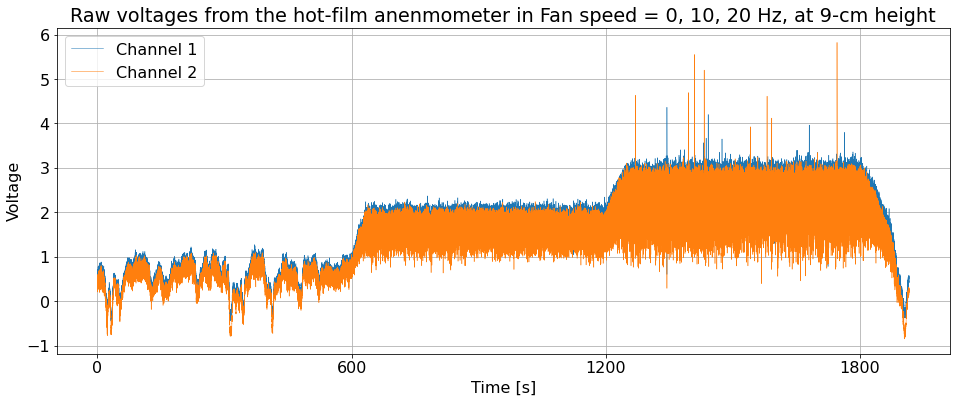

In [6]:
fig = plt.figure(figsize=(16, 6))
plt.plot(seconds, ch1, label='Channel 1', lw=0.5)
plt.plot(seconds, ch2, label='Channel 2', lw=0.5)
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Voltage')
plt.xticks(range(0, 2400, 600))
plt.grid()
plt.title('Raw voltages from the hot-film anenmometer in Fan speed = 0, 10, 20 Hz, at 9-cm height')

## Step 2: Read pressure data

In [7]:
data = pd.read_csv(DATAPATH + '/20200122/scanivalve_mps_20200122.csv')
time = data['FTime']

fan = range(0, 30, 10)
x = fetch['static_pressure']
run_seconds = 600

In [8]:
data

,Frame,Valve,XTime,Temp1,Temp2,Temp3,Temp4,Temp5,Temp6,Temp7,...,55Press,56Press,57Press,58Press,59Press,60Press,61Press,62Press,63Press,64Press
0,1,Px,0.0,41.19,41.06,41.25,40.94,41.50,41.06,41.38,...,-10.184814,-11.148104,-6.928781,-9.453717,-9.296730,-9.605772,-2.270167,-7.612617,-6.550287,-7.070973
1,2,Px,0.0,41.19,41.06,41.25,40.94,41.50,41.06,41.38,...,-10.347143,-10.997282,-6.731520,-9.692896,-9.204676,-9.728238,-2.455972,-7.352891,-6.452889,-6.972754
2,3,Px,0.0,41.19,41.06,41.25,40.88,41.44,41.06,41.38,...,-10.092143,-10.646322,-6.805493,-9.979746,-9.374813,-10.059472,-2.515202,-7.446590,-7.116179,-7.098507
3,4,Px,0.0,41.19,41.06,41.25,40.88,41.44,41.06,41.38,...,-9.993513,-10.509884,-7.005219,-10.021664,-9.663306,-10.080842,-2.426332,-7.473302,-7.259192,-7.120288
4,5,Px,0.0,41.19,41.06,41.25,40.88,41.44,41.06,41.38,...,-10.005019,-10.477829,-6.895904,-9.767691,-9.675635,-10.024129,-2.415570,-7.216247,-7.099740,-7.016315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,17996,Px,0.0,45.06,44.94,45.13,44.75,45.31,44.94,45.25,...,-8.652551,-8.462071,-4.683297,-7.456453,-5.810148,-8.684401,-0.208074,-5.161243,-4.497954,-6.301656
17996,17997,Px,0.0,45.06,44.94,45.13,44.75,45.31,44.94,45.25,...,-8.889058,-8.555359,-4.760557,-7.590426,-6.062478,-8.798647,-0.194512,-5.382134,-4.465488,-6.263026
17997,17998,Px,0.0,45.06,44.94,45.13,44.75,45.31,44.94,45.25,...,-8.565017,-8.441524,-4.916722,-7.389877,-6.221108,-8.894812,-0.386867,-5.169257,-4.623297,-6.092889
17998,17999,Px,0.0,45.00,44.94,45.13,44.75,45.31,44.94,45.25,...,-8.235016,-8.794949,-5.345764,-6.939466,-6.221108,-8.975360,-0.178279,-5.285147,-4.821790,-6.216588


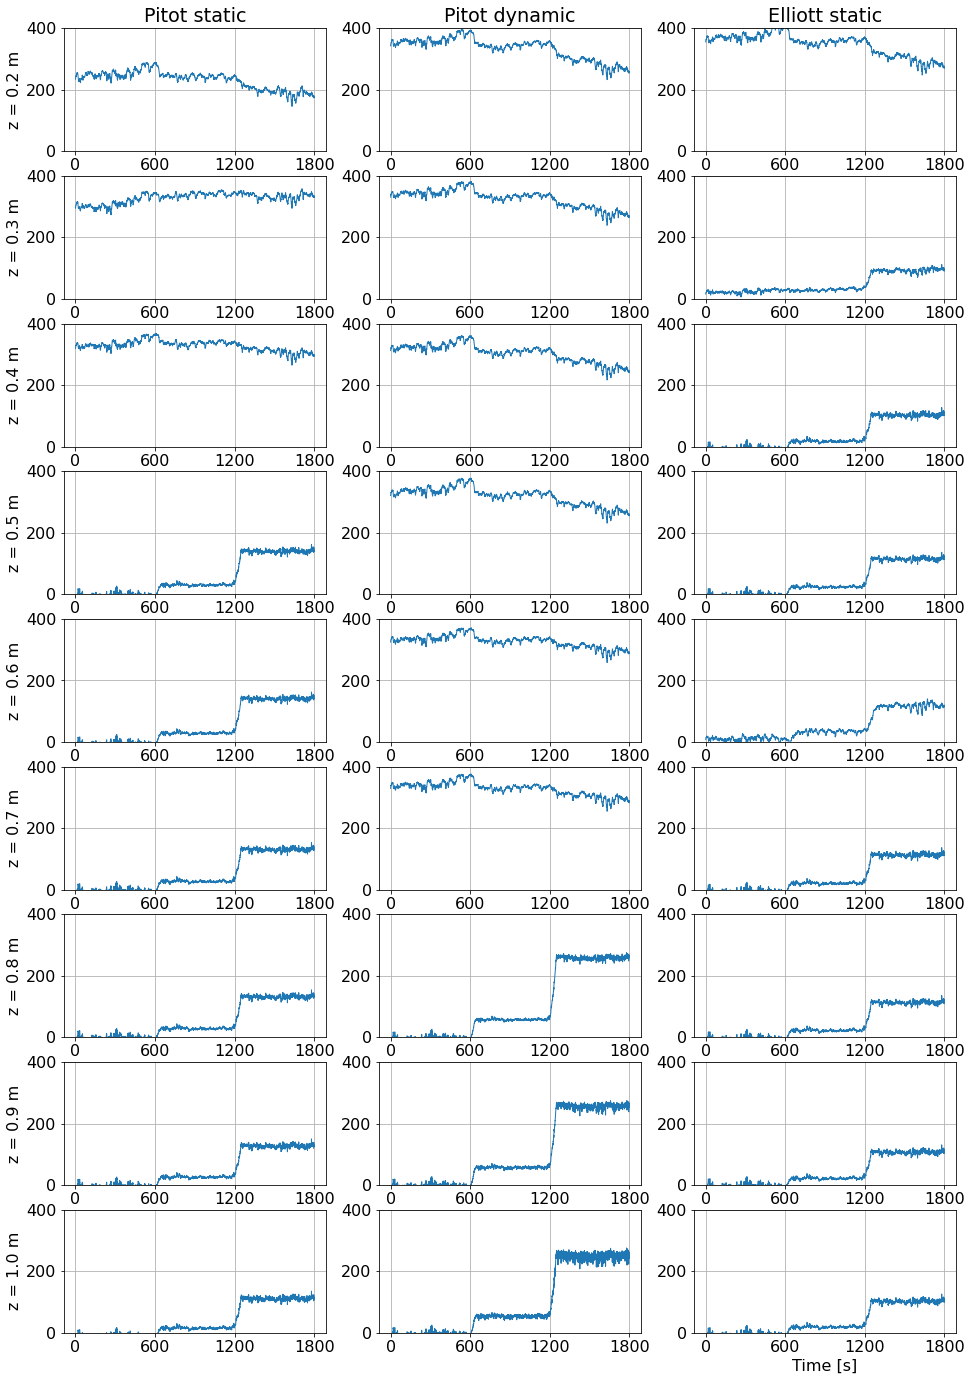

In [9]:
zlow = 1.
dz = 0.1
instrument_name = ['Pitot static', 'Pitot dynamic', 'Elliott static']
fig = plt.figure(figsize=(16, 24))
for k in range(9):
    z = zlow + k * dz - 0.8
    pressure_index = [9 + k * 3, 9 + k * 3 + 1, 9 + k * 3 + 2]
    for i in range(3):
        ax = plt.subplot2grid((9, 3), (k, i))
        ax.plot(time, data['%2.2i' % pressure_index[i] + 'Press'], lw=1)
        plt.ylim(0, 400)
        plt.grid()
        plt.xticks(range(0, 2400, 600))
        if k == 0: plt.title(instrument_name[i])
        if i == 0: plt.ylabel('z = %.1f m' % z)
    if k == 8: plt.xlabel('Time [s]')

## Step 3: Compute pitot wind speed from pressure data

In [10]:
def pitot_wind_speed(dp, rho=1.2):
    """Returns pitot wind speed given difference between dynamic and static pressure."""
    return (np.sqrt(2 * dp / rho))

In [11]:
pressure_record_length = data['%2.2iPress' % pressure_index[0]].size

pitot_dynamic = np.zeros((9, pressure_record_length))
pitot_static = np.zeros((9, pressure_record_length))

for k in range(9):
    z = zlow + k * dz - 0.8
    pressure_index = [9 + k * 3, 9 + k * 3 + 1, 9 + k * 3 + 2]
    pitot_static[k,:] = data['%2.2iPress' % pressure_index[0]]
    pitot_dynamic[k,:] = data['%2.2iPress' % pressure_index[1]]

In [12]:
pitot_wspd_all = pitot_wind_speed(np.abs(pitot_dynamic - pitot_static))

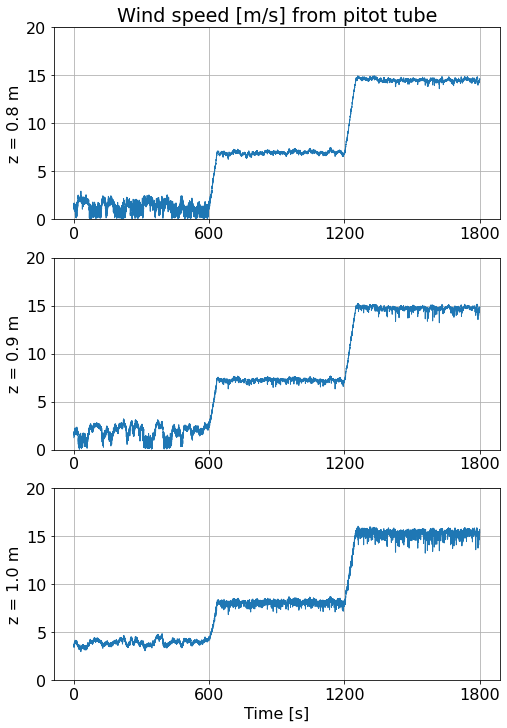

In [13]:
fig = plt.figure(figsize=(8, 12))
for k in range(6, 9):
    z = zlow + k * dz - 0.8
    ax = plt.subplot2grid((3, 1), (k - 6, 0))
    ax.plot(time, pitot_wspd_all[k,:], lw=1)
    plt.ylim(0, 20)
    plt.grid()
    plt.xticks(range(0, 2400, 600))
    if k == 6: plt.title('Wind speed [m/s] from pitot tube')
    plt.ylabel('z = %.1f m' % z)
    if k == 8: plt.xlabel('Time [s]')

In [14]:
pitot_wspd = pitot_wspd_all[8,:]
pitot_time = time

## Step 4: Fit hot-film voltages to pitot wind speed

In [15]:
Ueff = effective_velocity(pitot_wspd_all[8,:])

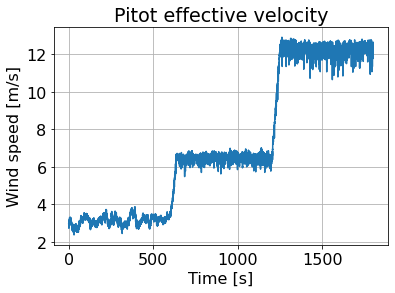

In [16]:
plt.plot(pitot_time, Ueff)
plt.xlabel('Time [s]')
plt.ylabel('Wind speed [m/s]')
plt.title('Pitot effective velocity')
plt.grid()

### Bin-average hot-film and pitot data to 1-minute before fitting

In [17]:
hotfilm_mask = (seconds >= 0.1) & (seconds <= 1800)

In [18]:
hotfilm_time = seconds[hotfilm_mask]
ch1 = ch1[hotfilm_mask]
ch2 = ch2[hotfilm_mask]

In [19]:
Ueff_binavg = binavg(Ueff, 600)
pitot_wspd_binavg = binavg(pitot_wspd, 600)
pitot_time_binavg = binavg(pitot_time, 600)

Text(0.5, 1.0, '1-minute bin-averaged pitot wind speed')

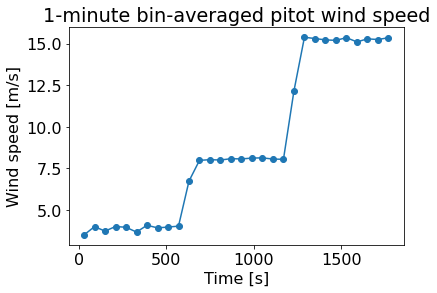

In [20]:
plt.plot(pitot_time_binavg, pitot_wspd_binavg, marker='o')
plt.xlabel('Time [s]')
plt.ylabel('Wind speed [m/s]')
plt.title('1-minute bin-averaged pitot wind speed')

In [21]:
ch1_binavg = binavg(ch1, 60000)
ch2_binavg = binavg(ch2, 60000)
hotfilm_time_binavg = binavg(hotfilm_time, 60000)

Text(0.5, 1.0, '1-minute bin-averaged hot-film voltages')

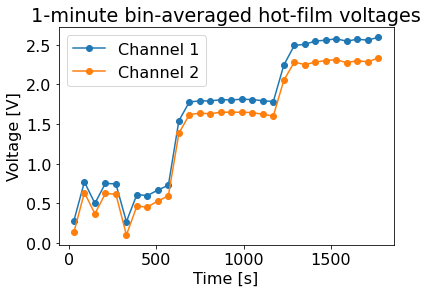

In [22]:
plt.plot(hotfilm_time_binavg, ch1_binavg, marker='o', label='Channel 1')
plt.plot(hotfilm_time_binavg, ch2_binavg, marker='o', label='Channel 2')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.title('1-minute bin-averaged hot-film voltages')

In [23]:
p1 = np.polyfit(ch1_binavg, Ueff_binavg, 2)
p2 = np.polyfit(ch2_binavg, Ueff_binavg, 2)

In [24]:
veff1 = np.polyval(p1, ch1)
veff2 = np.polyval(p2, ch2)

Text(0.5, 1.0, 'Effective velocity from hot-film')

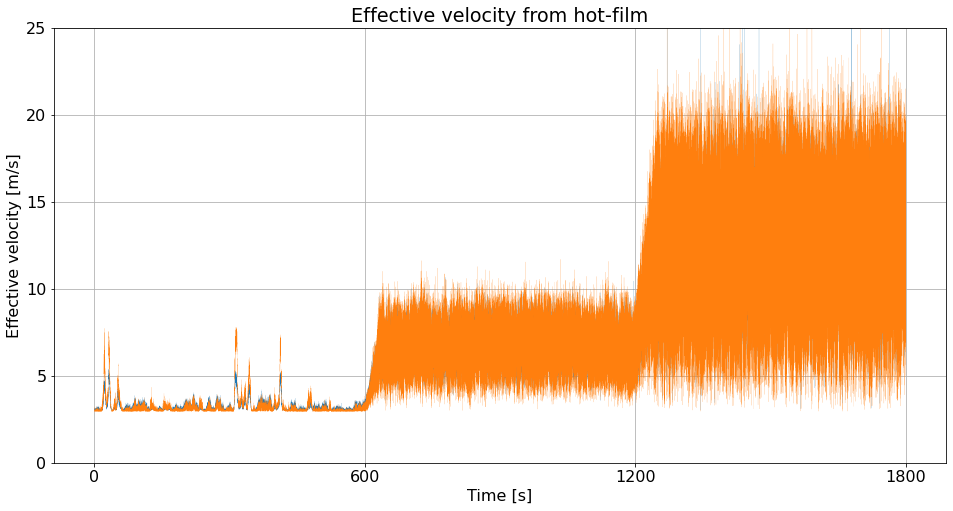

In [25]:
plt.figure(figsize=(16, 8))
plt.plot(hotfilm_time, veff1, lw=0.1, label='Channel 1')
plt.plot(hotfilm_time, veff2, lw=0.1, label='Channel 2')
plt.ylim(0, 25)
plt.xlabel('Time [s]')
plt.ylabel('Effective velocity [m/s]')
plt.grid()
plt.xticks(range(0, 2400, 600))
plt.title('Effective velocity from hot-film')

In [26]:
veff1[veff1 < 0.2] = 0.2
veff2[veff2 < 0.2] = 0.2
u, w = hotfilm_velocity(veff1, veff2)

/home/milan/Work/sustain/sustain-drag-2020/venv/lib/python3.6/site-packages/asist/hotfilm.py:19: RuntimeWarning: invalid value encountered in sqrt
  un = np.sqrt((veff1**2 - k1**2 * veff2**2) / (1 - k1**2 * k2**2))
/home/milan/Work/sustain/sustain-drag-2020/venv/lib/python3.6/site-packages/asist/hotfilm.py:20: RuntimeWarning: invalid value encountered in sqrt
  ut = np.sqrt((veff2**2 - k2**2 * veff1**2) / (1 - k1**2 * k2**2))


Text(0.5, 1.0, 'Hot-film velocity')

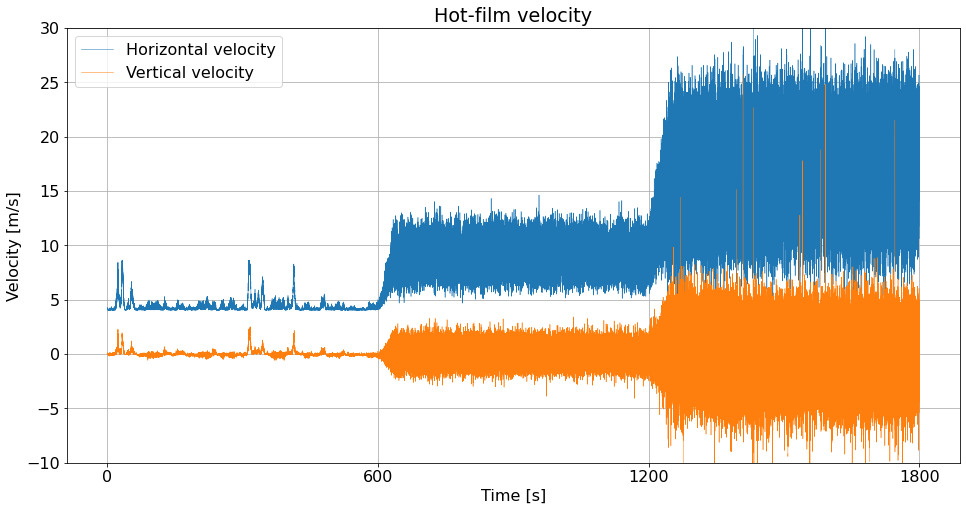

In [27]:
plt.figure(figsize=(16, 8))
plt.plot(hotfilm_time, u, lw=0.5, label='Horizontal velocity')
plt.plot(hotfilm_time, w, lw=0.5, label='Vertical velocity')
plt.legend()
plt.ylim(-10, 30)
plt.xticks(range(0, 2400, 600))
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Hot-film velocity')

## Step 5: Compute eddy-covariance stress

In [28]:
offset = 60 # allow 1-minute offset for fan spin-up

U, W, uw = [], [], []

for n, f in enumerate(fan):
    t0 = 0.1 + run_seconds * n + offset
    t1 = t0 + run_seconds - offset - 0.1
    mask = (hotfilm_time >= t0) & (hotfilm_time <= t1) & ~np.isnan(u)
    uw.append(np.mean(detrend(u[mask]) * detrend(w[mask])))
    U.append(np.mean(u[mask]))
    W.append(np.mean(w[mask]))
    print(n, f, U[-1], W[-1], uw[-1])

0 0 4.330796928521101 0.0003773060782453359 0.11398174713381205
1 10 9.08854000962675 0.08940109730178394 0.4035473946295077
2 20 16.82778538466873 0.10089852044112176 3.1533564887264913


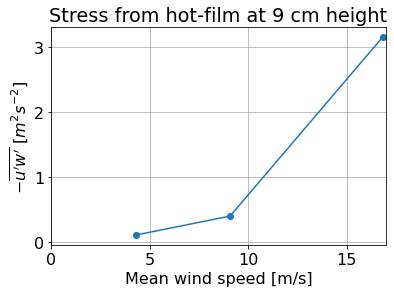

In [29]:
plt.plot(U, uw, marker='o')
plt.xlabel('Mean wind speed [m/s]')
plt.ylabel(r"$-\overline{u'w'}\ [m^2 s^{-2}]$")
plt.title('Stress from hot-film at 9 cm height')
plt.xlim(0, 17)
plt.grid()

## Now process hot-film at 60 cm height

In [30]:
def compute_stress_from_hotfilm(hotfilm_file, scanivalve_file, fan, duration):
    hotfilm_time, ch1, ch2, start_time = read_hotfilm(hotfilm_file)
    data = pd.read_csv(scanivalve_file)
    pitot_time = np.array(data['FTime'])
    x = fetch['static_pressure']
    run_seconds = 600

    pressure_record_length = data['01Press'].size
    pitot_dynamic = np.zeros((pressure_record_length))
    pitot_static = np.zeros((pressure_record_length))

    k = 6 # z = 0.8 m
    zlow = 1.
    dz = 0.1
    z = zlow + k * dz - 0.8
    pressure_index = [9 + k * 3, 9 + k * 3 + 1, 9 + k * 3 + 2]
    pitot_static = data['%2.2iPress' % pressure_index[0]]
    pitot_dynamic = data['%2.2iPress' % pressure_index[1]]
    pitot_wspd = pitot_wind_speed(np.abs(pitot_dynamic - pitot_static))
    
    pitot_mask = (pitot_time >= 0.1) & (pitot_time <= duration)
    pitot_wspd = pitot_wspd[pitot_mask]
    
    Ueff = effective_velocity(pitot_wspd)
    
    hotfilm_mask = (hotfilm_time >= 0.1) & (hotfilm_time <= duration)
    
    Ueff_binavg = binavg(Ueff, 600)
    ch1_binavg = binavg(ch1[hotfilm_mask], 60000)
    ch2_binavg = binavg(ch2[hotfilm_mask], 60000)
    
    p1 = np.polyfit(ch1_binavg, Ueff_binavg, 2)
    p2 = np.polyfit(ch2_binavg, Ueff_binavg, 2)
    
    veff1 = np.polyval(p1, ch1)
    veff2 = np.polyval(p2, ch2)
    
    veff1[veff1 < 0.2] = 0.2
    veff2[veff2 < 0.2] = 0.2
    u, w = hotfilm_velocity(veff1, veff2)
    
    offset = 60 # allow 1-minute offset for fan spin-up
    U, W, uw = [], [], []

    for n, f in enumerate(fan):
        t0 = 0.1 + run_seconds * n + offset
        t1 = t0 + run_seconds - offset - 0.1
        mask = (hotfilm_time >= t0) & (hotfilm_time <= t1) & ~np.isnan(u)
        uw.append(np.mean(detrend(u[mask]) * detrend(w[mask])))
        U.append(np.mean(u[mask]))
        W.append(np.mean(w[mask]))
        
    return U, W, uw

In [31]:
hotfilm_files = [DATAPATH + '/20200122/hotfilm_9cm_height.dat',
                 DATAPATH + '/hotfilm/hotfilm_jonswap_series1.txt',
                 DATAPATH + '/hotfilm/hotfilm_jonswap_series2.txt']

scanivalve_files = [DATAPATH + '/20200122/scanivalve_mps_20200122.csv',
                    DATAPATH + '/scanivalve/scanivalve_jonswap_stable.csv',
                    DATAPATH + '/scanivalve/scanivalve_jonswap_unstable.csv']

In [32]:
U1, W1, uw1 = compute_stress_from_hotfilm(hotfilm_files[0], scanivalve_files[0], range(0, 30, 10), 1800)
U2, W2, uw2 = compute_stress_from_hotfilm(hotfilm_files[1], scanivalve_files[1], range(0, 35, 5), 4200)
U3, W3, uw3 = compute_stress_from_hotfilm(hotfilm_files[2], scanivalve_files[2], range(0, 35, 5), 4200)

/home/milan/Work/sustain/sustain-drag-2020/venv/lib/python3.6/site-packages/asist/hotfilm.py:19: RuntimeWarning: invalid value encountered in sqrt
  un = np.sqrt((veff1**2 - k1**2 * veff2**2) / (1 - k1**2 * k2**2))
/home/milan/Work/sustain/sustain-drag-2020/venv/lib/python3.6/site-packages/asist/hotfilm.py:20: RuntimeWarning: invalid value encountered in sqrt
  ut = np.sqrt((veff2**2 - k2**2 * veff1**2) / (1 - k1**2 * k2**2))


Text(0.5, 1.0, 'Stress from hot-film at different heights')

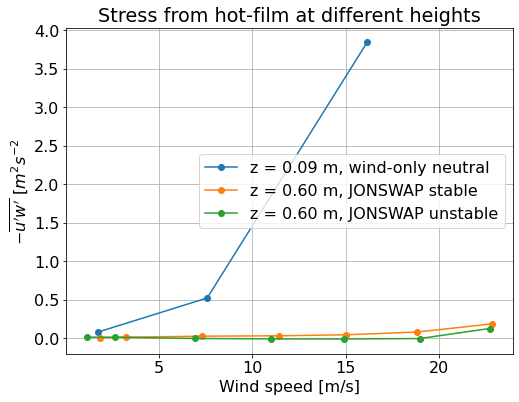

In [33]:
fig = plt.figure(figsize=(8, 6))
plt.plot(U1, uw1, marker='o', label='z = 0.09 m, wind-only neutral')
plt.plot(U2, uw2, marker='o', label='z = 0.60 m, JONSWAP stable')
plt.plot(U3, uw3, marker='o', label='z = 0.60 m, JONSWAP unstable')
plt.legend()
plt.grid()
plt.xlabel('Wind speed [m/s]')
plt.ylabel(r"$-\overline{u'w'}\ [m^2 s^{-2}$")
plt.title('Stress from hot-film at different heights')

Text(0.5, 1.0, 'Stress from hot-film at different heights')

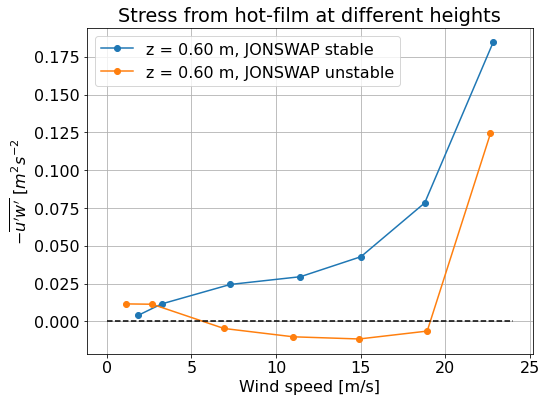

In [34]:
fig = plt.figure(figsize=(8, 6))
plt.plot(U2, uw2, marker='o', label='z = 0.60 m, JONSWAP stable')
plt.plot(U3, uw3, marker='o', label='z = 0.60 m, JONSWAP unstable')
plt.legend()
plt.grid()
plt.plot([0, 24], [0, 0], 'k--')
plt.xlabel('Wind speed [m/s]')
plt.ylabel(r"$-\overline{u'w'}\ [m^2 s^{-2}$")
plt.title('Stress from hot-film at different heights')

## Step 6: Compute vertical stress gradient

In [35]:
rhoa = 1.2 

tau1 = rhoa * np.array([uw1[1], uw1[2]])
tau2 = rhoa * np.array([uw2[2], uw2[4]])

U = np.array([U2[2], U2[4]])

dz = (0.6 - 0.09)

dtaudz = (tau2 - tau1) / dz

## Step 7: Compute along-tank pressure gradient

In [36]:
def get_dpdx_from_scanivalve(scanivalve_file, fan):
    data = pd.read_csv(scanivalve_file)
    time = data['FTime']
    run_seconds = 600
    
    pmean = np.zeros((8, len(fan)))
    pstd = np.zeros((8, len(fan)))
    
    for i in range(8):
        pressure_index = i + 1
        for n in range(len(fan)):
            t0 = n * run_seconds + 60
            t1 = t0 + run_seconds - 60
            mask = (time >= t0) & (time <= t1)
            pres = data['%2.2iPress' % pressure_index][mask]
            pmean[i,n] = np.mean(pres)
            pstd[i,n] = np.std(pres)
    
    dpdx = np.zeros((len(fan)))
    for n in range(dpdx.size):
        p = np.polyfit(x, pmean[:,n], 1)
        fit = np.polyval(p, x)
        dpdx[n] = (fit[-1] - fit[0]) / (x[-1] - x[0])
    
    return dpdx

In [37]:
dpdx_windonly_9cm = get_dpdx_from_scanivalve(DATAPATH + '/20200122/scanivalve_mps_20200122.csv', range(0, 30, 10))
dpdx_windonly = get_dpdx_from_scanivalve(DATAPATH + '/20191203/scanivalve_mps_20191203.csv', range(0, 55, 5))
dpdx_jonswap_stable = get_dpdx_from_scanivalve(DATAPATH + '/scanivalve/scanivalve_jonswap_stable.csv', range(0, 65, 5))
dpdx_jonswap_unstable = get_dpdx_from_scanivalve(DATAPATH + '/scanivalve/scanivalve_jonswap_unstable.csv', range(0, 65, 5))

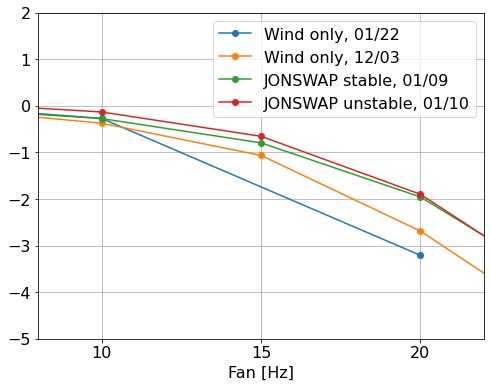

In [38]:
fig = plt.figure(figsize=(8, 6))
plt.plot(range(0, 30, 10), dpdx_windonly_9cm, marker='o', label='Wind only, 01/22')
plt.plot(range(0, 55, 5), dpdx_windonly, marker='o', label='Wind only, 12/03')
plt.plot(range(0, 65, 5), dpdx_jonswap_stable, marker='o', label='JONSWAP stable, 01/09')
plt.plot(range(0, 65, 5), dpdx_jonswap_unstable, marker='o', label='JONSWAP unstable, 01/10')
plt.xlabel('Fan [Hz]')
plt.legend()
plt.xticks(range(5, 30, 5))
plt.xlim(8, 22)
plt.ylim(-5, 2)
plt.grid()

## Step 8: Compute linear fit of $\dfrac{\partial \tau}{\partial z}$ to $\dfrac{\partial p}{\partial x}$

In [39]:
dpdx1 = dpdx_windonly_9cm[1:]
dpdx2 = dpdx_jonswap_stable[[2, 4]]

In [40]:
mat = loadmat('data/hidrag/taugrad.mat')
pp_asist = mat['pp1'][0]
np.polyval(pp_asist, dpdx2)

array([0.26234142, 1.32793425])

Text(0.5, 1.0, 'Vertical stress gradient vs. along-tank pressure gradient')

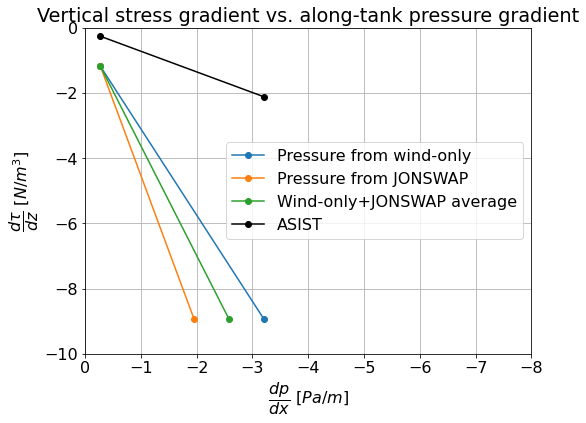

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(dpdx1, dtaudz, marker='o', label='Pressure from wind-only')
plt.plot(dpdx2, dtaudz, marker='o', label='Pressure from JONSWAP')
plt.plot(0.5 * (dpdx1 + dpdx2), dtaudz, marker='o', label='Wind-only+JONSWAP average')
plt.plot(dpdx1, - np.polyval(pp_asist, dpdx1), 'k-', marker='o', label='ASIST')
plt.legend()
plt.xlim(0, -8)
plt.ylim(-10, 0)
plt.grid()
plt.xlabel(r'$\dfrac{dp}{dx}\ [Pa/m]$')
plt.ylabel(r'$\dfrac{d\tau}{dz}\ [N/m^3]$')
plt.title('Vertical stress gradient vs. along-tank pressure gradient')